In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import sweetviz as sv
sv.config_parser.read('../sweetviz_settings/sweetviz_settings.ini')
# sv.config_parser.read('sweetviz_setting.ini')
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import lightgbm as gbm
from sklearn.ensemble import RandomForestRegressor as RF

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# データの読み込み

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('train shape', train.shape)
print('test shape' , test.shape)


train shape (207, 12)
test shape (40, 11)


# 前処理
1. remarks : trainにしかない項目はnanに変更
1. weather : 雷電、雪 は雨に丸め込み
1. 祝日フラグ : 前祝日、後祝日のフラグ

追記
1. weatherの晴れ、快晴を丸め込み、 曇・薄曇の丸め込み

In [3]:
### 不要な項目を消す系

# remarksで１個しかないカテゴリは　カテゴリなしにする。
def replace_remarks_cat(df):
    _df = df['remarks'].value_counts().copy()
    _df = _df[_df < 2]
    
    
    for i in _df.index:
        df['remarks'].loc[df['remarks'] == i] = np.nan

# weather 雪と雷電を　雨に置き換え
def replace_weather_cat(df):
    _df = df['weather'].value_counts()
    _df = _df[_df < 2]
    
    for i in _df.index:
        df['weather'].loc[df['weather'] == i] = '雨'

# category_encoding関数
def encoding_func(df, encoding_col_name_list):
    def which_col_is_object_func(df):
        # 列がobjectを抽出してリストに
        keys = list(df.dtypes.loc[df.dtypes == 'object'].index)
        # 辞書化
        values = list(range(len(object_list)))
        object_dic = dict(zip(keys, values))
        print(object_dic)
    
    
    # カテゴリエンコーダーする
    ce_oe = ce.OrdinalEncoder(cols = encoding_col_name_list, handle_unknown = 'impute')
    df = ce_oe.fit_transform(df)

    # カテゴリ番号の確認
    
    for i in range(len(encoding_col_name_list)):
        print(pd.DataFrame(ce_oe.category_mapping[i]))
        print()
    return df


# 休日前flg (category encodingのあとにやる)
def before_holiday_func(df):
    '''
    祝日の前の日にフラグを立てる。
    category encodingのあとに使うこと。
    '''
    df['before_holiday'] = 0
    for i in range(len(df)):
        
        if df['week'].diff(-1).iloc[i] == -1.0:
            df['before_holiday'].iloc[i] = 0        
        
        elif i == len(df):
            df['before_holiday'].iloc[i] = 0
        
        else:
            df['before_holiday'].iloc[i] = 1

            
# 休日後flg (category encodingのあとにやる)
def after_holiday_func(df):
    '''
    祝日の次の日にフラグを立てる。
    category encodingのあとに使うこと。
    '''
    
    df['after_holiday'] = 0

    for i in range(len(df)):
        if i == 1:
            df['week'].iloc[i] == 1
            
        elif df['week'].diff(1).iloc[i] == 1.0:
            df['after_holiday'].iloc[i] = 0
            
        else:
            df['after_holiday'].iloc[i] = 1

def replace_weather_sunny_and_cloudy(df, weather):
    df['weather'] = df['weather'].loc['']

## trainとtestの結合

In [4]:
# trainとtestの識別列を追加
train['train_flg'] = True
test['train_flg'] = False

# データの結合
all_data = pd.concat([train, test], axis = 0)
proc_data = all_data.copy()
proc_data['datetime'] = pd.to_datetime(proc_data['datetime'])

## カテゴリデータの処理

In [5]:
# カテゴリデータの処理
replace_remarks_cat(all_data)

# weatherのtrainにしかないカテゴリを丸め込み
replace_weather_cat(all_data)
# # weatherの薄曇ー曇、 晴れー快晴を丸め込み
# proc_data['weather'].loc[proc_data['weather'] == '薄曇'] = '曇'
# proc_data['weather'].loc[proc_data['weather'] == '晴れ'] = '快晴'


# nan値の埋め
proc_data['payday'] = proc_data['payday'].fillna(0)
proc_data['remarks'] = proc_data['remarks'].fillna(0)
proc_data['event'] = proc_data['event'].fillna(0)

# 降水量の'--'の処理
proc_data['precipitation'] = proc_data['precipitation'].apply(lambda x : -1 if x == '--' else float(x))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## 数値データの処理

In [6]:
# kcalのnanをmedianで埋める
proc_data['kcal'] = proc_data['kcal'].fillna(proc_data['kcal'].mean())

## エンコーディング 

In [7]:
# encoding
encoding_col_name_list = ['week',
                         'remarks',
                         'event',
                         'weather']

proc_data = encoding_func(proc_data, encoding_col_name_list)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


      col  mapping data_type
月    week        1    object
火    week        2    object
水    week        3    object
木    week        4    object
金    week        5    object
NaN  week       -2    object

                              col  mapping data_type
0                         remarks        1    object
鶏のレモンペッパー焼（50食）、カレー（42食）  remarks        2    object
酢豚（28食）、カレー（85食）          remarks        3    object
お楽しみメニュー                  remarks        4    object
料理長のこだわりメニュー              remarks        5    object
手作りの味                     remarks        6    object
スペシャルメニュー（800円）           remarks        7    object
近隣に飲食店複合ビルオープン            remarks        8    object
NaN                       remarks       -2    object

                 col  mapping data_type
0              event        1    object
ママの会           event        2    object
キャリアアップ支援セミナー  event        3    object
NaN            event       -2    object

         col  mapping data_type
快晴   weather        1    object


## 特徴量作成

In [8]:
# メニューに対する処理
proc_data['curry'] = proc_data['name'].apply(lambda x : 1 if 'カレー' in x else 0)
# all_data['menchikatsu'] = all_data['name'].apply(lambda x : 1 if 'メンチカツ' in x else 0)

In [9]:
# 祝日前後の平日にflg
after_holiday_func(proc_data)
before_holiday_func(proc_data)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### 販売量に対する処理 (時系列の特徴量)

#### 変動率

In [10]:
'''
販売量が現象傾向 という情報を追加したい。
1. trainをshiftしてtestの販売量を埋める
2. trainのnan値になった箇所をmeanで埋める
3. 各yに対して、pcf_changeで特徴量を作る
4. モデル作成時は、最初のmeanを埋めた行を学習させない（使わない)
'''

proc_data['shift_y'] = proc_data['y'].shift(len(test)).fillna(proc_data['y'].median())
proc_data['shift_2y'] = proc_data['y'].shift(len(test)+1).fillna(proc_data['y'].median())
proc_data['pcf_change1'] = proc_data['shift_y'].pct_change(1)
proc_data['pcf_change3'] = proc_data['shift_y'].pct_change(3)
proc_data['pcf_change5'] = proc_data['shift_y'].pct_change(5)

#### 移動平均

In [11]:
proc_data['rolling_mean3'] = proc_data['shift_y'].rolling(3).mean()
proc_data['rolling_mean5'] = proc_data['shift_y'].rolling(5).mean()

# 学習

## Xとyに分割

In [12]:
proc_data.columns

Index(['datetime', 'y', 'week', 'soldout', 'name', 'kcal', 'remarks', 'event',
       'payday', 'weather', 'precipitation', 'temperature', 'train_flg',
       'curry', 'after_holiday', 'before_holiday', 'shift_y', 'shift_2y',
       'pcf_change1', 'pcf_change3', 'pcf_change5', 'rolling_mean3',
       'rolling_mean5'],
      dtype='object')

In [13]:
# 前処理したデータをtrain と testに分割
proc_data_train = proc_data.loc[proc_data['train_flg'] == True]
proc_data_test = proc_data.loc[proc_data['train_flg'] == False]

# 不要な列の削除 datetime , name ,  'temperature'
proc_data_train = proc_data_train[['y', 'soldout', 'kcal', 'remarks', 'event',
       'payday', 'weather', 'precipitation',
       'curry', 'shift_y', 'shift_2y', 'pcf_change1',
       'pcf_change3', 'pcf_change5', 'rolling_mean3', 'rolling_mean5']]
proc_data_test = proc_data_test[['y', 'soldout', 'kcal', 'remarks', 'event',
       'payday', 'weather', 'precipitation',
       'curry', 'shift_y', 'shift_2y', 'pcf_change1',
       'pcf_change3', 'pcf_change5', 'rolling_mean3', 'rolling_mean5']]



# 不要な列の削除 feature trace
# proc_data_train = proc_data_train[['y', 'soldout', 'kcal', 'remarks', 'event',
#        'payday', 'weather', 'precipitation',
#        'curry', 'shift_y', 'shift_2y',
#        'rolling_mean3', 'rolling_mean5']]
# proc_data_test = proc_data_test[['y', 'soldout', 'kcal', 'remarks', 'event',
#        'payday', 'weather', 'precipitation',
#        'curry', 'shift_y', 'shift_2y',
#        'rolling_mean3', 'rolling_mean5']]


In [14]:
proc_data_train.columns

Index(['y', 'week', 'soldout', 'kcal', 'remarks', 'event', 'payday', 'weather',
       'precipitation', 'curry', 'shift_y', 'shift_2y', 'pcf_change1',
       'pcf_change3', 'pcf_change5', 'rolling_mean3', 'rolling_mean5'],
      dtype='object')

In [15]:
proc_data_train

,y,week,soldout,kcal,remarks,event,payday,weather,precipitation,curry,shift_y,shift_2y,pcf_change1,pcf_change3,pcf_change5,rolling_mean3,rolling_mean5
0,90.0,1,0,407.381188,1,1,0.0,1,-1.0,0,78.0,78.0,NaN,NaN,NaN,NaN,NaN
1,101.0,2,1,407.381188,1,1,0.0,1,-1.0,0,78.0,78.0,0.000000,NaN,NaN,NaN,NaN
2,118.0,3,0,407.381188,1,1,0.0,1,-1.0,0,78.0,78.0,0.000000,NaN,NaN,78.000000,NaN
3,120.0,4,1,407.381188,1,1,0.0,1,-1.0,0,78.0,78.0,0.000000,0.000000,NaN,78.000000,NaN
4,130.0,5,1,407.381188,1,1,0.0,1,-1.0,0,78.0,78.0,0.000000,0.000000,NaN,78.000000,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,59.0,3,1,408.000000,1,1,0.0,2,0.0,0,56.0,53.0,0.056604,0.056604,0.098039,54.666667,54.0
203,50.0,4,0,394.000000,1,1,0.0,2,0.0,0,62.0,56.0,0.107143,0.127273,0.169811,57.000000,55.8
204,45.0,5,0,407.381188,7,3,0.0,3,-1.0,0,83.0,62.0,0.338710,0.566038,0.566038,67.000000,61.8
205,56.0,1,1,404.000000,1,1,0.0,1,-1.0,0,65.0,83.0,-0.216867,0.160714,0.181818,70.000000,63.8


In [16]:
# shiftで前半30個くらいのyのデータが全部同じ値なので、学習からはずす
# .drop(df.index[])で行削除ができるが、該当するindex名を全て削除してしまうため、testデータのindexも削除されてしまう。
# なので、train と testに分割してからtrainに対して実施する(全データconcatしてる状態でやるとtestデータが消える)
proc_data_train.drop(proc_data.index[:len(test)], inplace = True, axis = 'index')

In [17]:
proc_data_train.head(20)

,y,week,soldout,kcal,remarks,event,payday,weather,precipitation,curry,shift_y,shift_2y,pcf_change1,pcf_change3,pcf_change5,rolling_mean3,rolling_mean5
40,92.0,5,1,418.0,2,1,0.0,1,-1.0,1,90.0,78.0,0.153846,0.153846,0.153846,82.000000,80.4
41,126.0,1,1,415.0,1,1,0.0,1,-1.0,0,101.0,90.0,0.122222,0.294872,0.294872,89.666667,85.0
42,120.0,2,0,445.0,1,1,0.0,1,-1.0,0,118.0,101.0,0.168317,0.512821,0.512821,103.000000,93.0
43,121.0,3,1,450.0,1,1,0.0,1,-1.0,0,120.0,118.0,0.016949,0.333333,0.538462,113.000000,101.4
44,105.0,4,1,448.0,1,1,0.0,2,-1.0,0,130.0,120.0,0.083333,0.287129,0.666667,122.666667,111.8
45,92.0,5,1,460.0,1,1,0.0,1,-1.0,0,135.0,130.0,0.038462,0.144068,0.500000,128.333333,120.8
46,139.0,1,1,445.0,1,1,0.0,3,-1.0,1,145.0,135.0,0.074074,0.208333,0.435644,136.666667,129.6
47,121.0,2,1,430.0,1,1,0.0,5,0.0,0,140.0,145.0,-0.034483,0.076923,0.186441,140.000000,134.0
48,126.0,3,1,420.0,1,1,0.0,1,-1.0,0,151.0,140.0,0.078571,0.118519,0.258333,145.333333,140.2
49,111.0,4,1,435.0,1,1,0.0,2,-1.0,0,116.0,151.0,-0.231788,-0.200000,-0.107692,135.666667,137.4


## cv

In [18]:
X = proc_data_train.drop(columns = 'y')
y = proc_data_train['y']
print(X.shape, y.shape)

X_index = X.index

(167, 16) (167,)


In [19]:
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

In [20]:
folds = TimeSeriesSplit(n_splits = 5, test_size = 20)
cv = list(folds.split(X, y))

In [21]:
folds = TimeSeriesSplit(n_splits = 5, test_size = 20)



train_score = []
valid_score = []
models = []
train_pred_vs_data_df_list = []
valid_pred_vs_data_df_list = []

for i, (train_index, valid_index) in enumerate(folds.split(proc_data_train)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    print('-------------------------------')
    print('model No: ', i)
    
    model = RF(n_estimators=100,max_depth=4,random_state=777)
    model.fit(X_train, y_train)
    
    # モデル評価
    # trainのモデル評価
    train_pred = model.predict(X_train)# arrayで返ってくる
    train_pred_vs_data_df = pd.concat([y_train, pd.Series(train_pred,index = train_index)],
                                      axis = 1)# 真値と予測値のｄｆ作成
    train_pred_vs_data_df.columns = ['true','pred']
    train_pred_vs_data_df_list.append(train_pred_vs_data_df)
    
    # validのモデル評価
    valid_pred = model.predict(X_valid)
    valid_pred_vs_data_df = pd.concat([y_valid, pd.Series(valid_pred, index = valid_index)],
                                      axis = 1)
    valid_pred_vs_data_df.columns = ['true','pred']
    valid_pred_vs_data_df_list.append(valid_pred_vs_data_df)
    
    train_score.append(np.sqrt(mean_squared_error(train_pred_vs_data_df['true'],train_pred_vs_data_df['pred'])))
    valid_score.append(np.sqrt(mean_squared_error(valid_pred_vs_data_df['true'],valid_pred_vs_data_df['pred'])))
    
    models.append(model)
    
   

-------------------------------
model No:  0
-------------------------------
model No:  1
-------------------------------
model No:  2
-------------------------------
model No:  3
-------------------------------
model No:  4


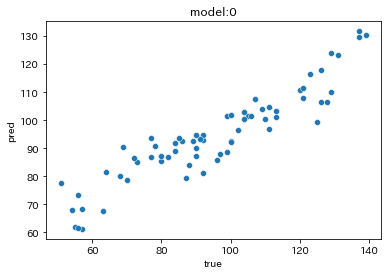

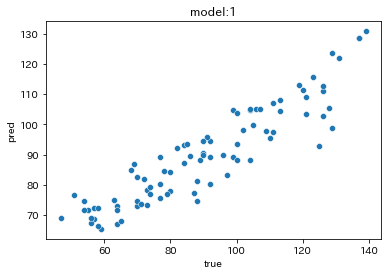

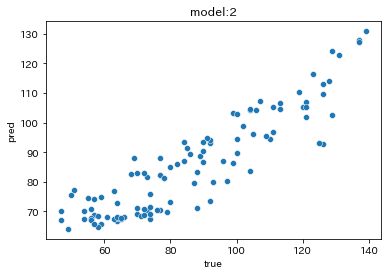

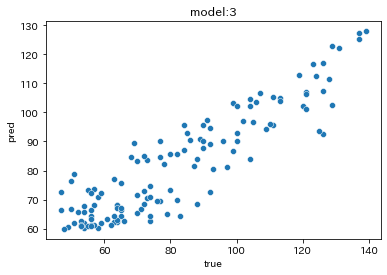

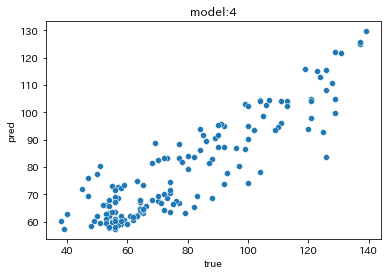

In [22]:
for i in range(len(train_pred_vs_data_df_list)):
    sns.scatterplot(x = 'true', y = 'pred', data = train_pred_vs_data_df_list[i])
    plt.title(label = 'model:'+str(i))
    plt.show()


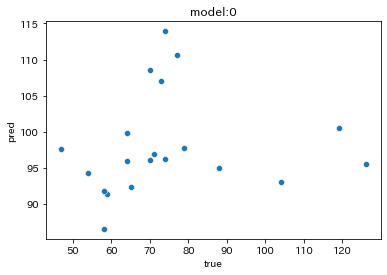

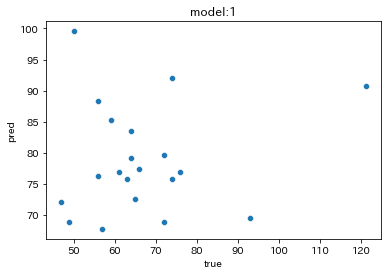

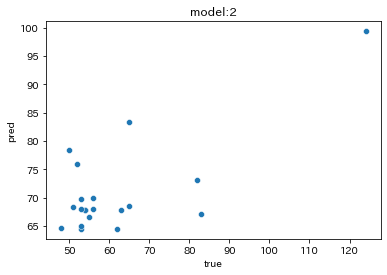

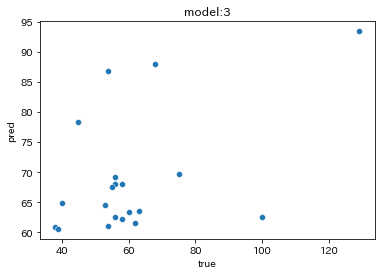

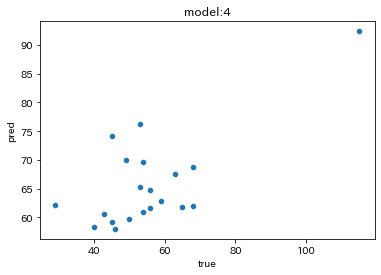

In [23]:
for i in range(len(valid_pred_vs_data_df_list)):
    sns.scatterplot(x = 'true', y = 'pred', data = valid_pred_vs_data_df_list[i])
    plt.title(label = 'model:'+str(i))
    plt.show()


In [33]:
cv[4][0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146])

In [47]:
valid_pred_vs_data_df_list

[     true        pred
 67   47.0   97.626926
 68   88.0   94.945008
 69   59.0   91.412739
 70   58.0   86.574021
 71   73.0  107.045454
 72   70.0   96.072437
 73   64.0   95.947901
 74   58.0   91.840333
 75  126.0   95.581603
 76   70.0  108.559268
 77   71.0   96.955458
 78  104.0   93.021952
 79   54.0   94.296997
 80   65.0   92.437948
 81   77.0  110.636190
 82   79.0   97.800592
 83   74.0   96.266935
 84   64.0   99.805672
 85  119.0  100.494994
 86   74.0  113.913329,
       true       pred
 87    59.0  85.274413
 88    47.0  72.024008
 89    64.0  79.113525
 90    93.0  69.431014
 91    74.0  75.714503
 92    56.0  76.164800
 93    50.0  99.556883
 94    72.0  68.829854
 95   121.0  90.759144
 96    76.0  76.907697
 97    63.0  75.788690
 98    66.0  77.315760
 99    56.0  88.281727
 100   57.0  67.688395
 101   72.0  79.540551
 102   61.0  76.850270
 103   64.0  83.529888
 104   49.0  68.769096
 105   74.0  92.088518
 106   65.0  72.585891,
       true       pred
 107   54

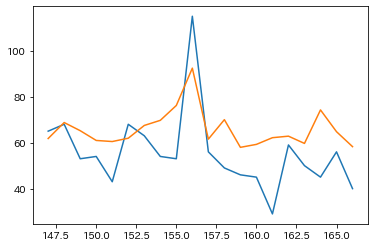

In [50]:
plt.plot(valid_pred_vs_data_df_list[4]['true'])
plt.plot(valid_pred_vs_data_df_list[4]['pred'])


In [66]:
valid_pred_vs_data_df_list

[     true        pred
 67   47.0   97.626926
 68   88.0   94.945008
 69   59.0   91.412739
 70   58.0   86.574021
 71   73.0  107.045454
 72   70.0   96.072437
 73   64.0   95.947901
 74   58.0   91.840333
 75  126.0   95.581603
 76   70.0  108.559268
 77   71.0   96.955458
 78  104.0   93.021952
 79   54.0   94.296997
 80   65.0   92.437948
 81   77.0  110.636190
 82   79.0   97.800592
 83   74.0   96.266935
 84   64.0   99.805672
 85  119.0  100.494994
 86   74.0  113.913329,
       true       pred
 87    59.0  85.274413
 88    47.0  72.024008
 89    64.0  79.113525
 90    93.0  69.431014
 91    74.0  75.714503
 92    56.0  76.164800
 93    50.0  99.556883
 94    72.0  68.829854
 95   121.0  90.759144
 96    76.0  76.907697
 97    63.0  75.788690
 98    66.0  77.315760
 99    56.0  88.281727
 100   57.0  67.688395
 101   72.0  79.540551
 102   61.0  76.850270
 103   64.0  83.529888
 104   49.0  68.769096
 105   74.0  92.088518
 106   65.0  72.585891,
       true       pred
 107   54

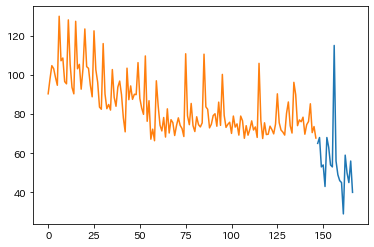

In [65]:
plt.plot(valid_pred_vs_data_df_list[4]['true'])



valid_ensamble_pred = [model.predict(X_train) for model in models]
valid_ensamble_pred = np.mean(valid_ensamble_pred, axis = 0)

plt.plot(valid_ensamble_pred)

In [51]:
train_score

[10.612118731692512,
 11.387258949748404,
 11.717582736747978,
 11.675827463300962,
 12.504623423414586]

In [52]:
valid_score

[31.035701798224377,
 20.981302978820576,
 15.658584275515437,
 19.663391307368247,
 16.05802811555637]

In [26]:
proc_data['weather'].unique()

array([1, 2, 3, 4, 5, 6, 7])

memo
feature traceのスコア  
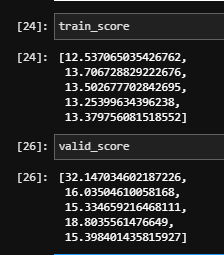

memo feature traceのスコアで曇、晴れ 丸め込み

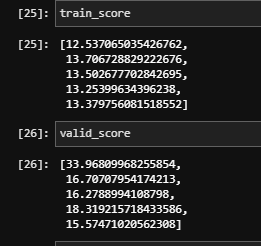

memo  
自分で特徴量考えたやつ。 一番だめかも  過学習しはじめてる。  
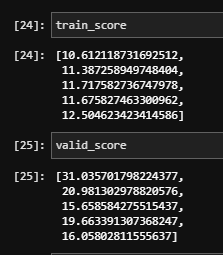

# 予測

In [55]:
X_test = proc_data_test.drop(columns = 'y')
y_test = proc_data_test['y']
print(X_test.shape, y_test.shape)

(40, 16) (40,)


In [68]:
y_test_pred = [model.predict(X_test) for model in models]
y_test_pred = np.mean(y_test_pred, axis = 0)

<AxesSubplot:xlabel='datetime', ylabel='y'>

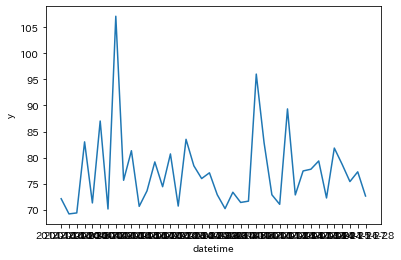

In [69]:
y_test_pred = pd.DataFrame(y_test_pred)
sample_data = pd.read_csv('sample.csv', header = None)
submit_data = pd.concat([sample_data[0], y_test_pred], axis = 1)
submit_data.columns = ['datetime', 'y']
sns.lineplot(x = 'datetime', y = 'y', data = submit_data)

### 提出データ

In [32]:
submit_data.to_csv('submit_211101_RF_weathers-曇薄曇group-晴れ快晴group_cv13-83.csv',index = False, header = False)

# testデータで予測

## モデルの作成
全データを学習として使う。

In [33]:
X = proc_data_train.drop(columns = 'y')
y = proc_data_train['y']
print(X.shape, y.shape)

X_index = X.index

(167, 14) (167,)


In [74]:
X_test = proc_data_test.drop(columns = 'y')
y_test = proc_data_test['y']
print(X_test.shape, y_test.shape)


(40, 12) (40,)


In [70]:
X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


model = RF(n_estimators=100,max_depth=4,random_state=777)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=4, random_state=777)

<AxesSubplot:xlabel='datetime', ylabel='y'>

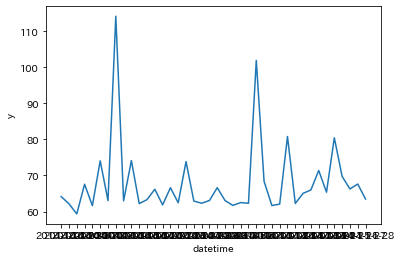

In [71]:
y_test_pred_all_train_data = model.predict(X_test)
y_test_pred_all_train_data = pd.DataFrame(y_test_pred_all_train_data)
sample_data_all_train_data = pd.read_csv('sample.csv', header = None)
submit_data_all_train_data = pd.concat([sample_data_all_train_data[0], y_test_pred_all_train_data], axis = 1)
submit_data_all_train_data.columns = ['datetime', 'y']
sns.lineplot(x = 'datetime', y = 'y', data = submit_data_all_train_data)

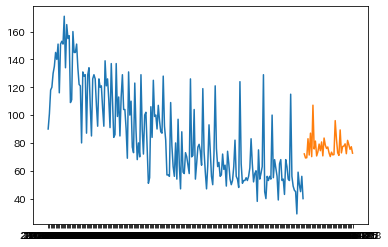

In [95]:
plt.plot(all_data['datetime'], all_data['y'])

plt.plot(submit_data['datetime'], submit_data['y'])